In [1]:
import rebound
import reboundx
import pandas as pd
import numpy as np
from numpy import genfromtxt
import csv
import scipy
from scipy import signal

from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline

In [2]:
radeg = np.pi/180

########################
# Define functions for adding a number of generated Trojan asteroids at ~L4/L5
########################

def add_L4(sim, number):
    a_rand = np.random.normal(20,2,size=number)
    a_rand = a_rand/100 + 5
    e_rand = np.random.normal(9,2,size=number)
    e_rand = e_rand/100
    w_rand = np.random.normal(170,4,size=number)*radeg
    half = int(number/2)
    i_rand1 = np.random.normal(9,4,size=half+1)*radeg
    i_rand2 = np.random.normal(-9,4,size=half)*radeg
    i_rand = np.concatenate((i_rand1,i_rand2))
        
    for i in range(number):
        sem = a_rand[i]
        ecc = e_rand[i]
        icl = i_rand[i]
        Ome = w_rand[i]
        has = 'L4 {0}'.format(i)
        sim.add(m=0, primary=sim.particles['Sun'], a=sem, e=ecc, inc=icl, Omega=Ome, hash=has)
    return

def add_L5(sim, number):
    a_rand = np.random.normal(20,2,size=number)
    a_rand = a_rand/100 + 5
    e_rand = np.random.normal(9,2,size=number)
    e_rand = e_rand/100
    w_rand = np.random.normal(50,4,size=number)*radeg
    half = int(number/2)
    i_rand1 = np.random.normal(9,4,size=half+1)*radeg
    i_rand2 = np.random.normal(-9,4,size=half)*radeg
    i_rand = np.concatenate((i_rand1,i_rand2))
    
    for i in range(number):
        sem = a_rand[i]
        ecc = e_rand[i]
        icl = i_rand[i]
        Ome = w_rand[i]
        has = 'L5 {0}'.format(i)
        sim.add(m=0, primary=sim.particles['Sun'], a=sem, e=ecc, inc=icl, Omega=Ome, hash=has)
    return

In [3]:
def masses(x):
    # for input array of time values, approximate M_star (in M_sol) at those times in its life
    y = np.zeros_like(x)
    for i, time in enumerate(x):
        if (time <= 1.132e10):
            y[i] = 1
        elif (1.132e10 < time <= 1.1336e10):
            y[i] = 0.05 * (708.5 - time/(1.6e7))**(1/3) + .95
        elif (1.1336e10 < time <= 1.1463e10):
            y[i] =  -8**((time - 1.1463e10)/574511)/2.4 + .95
        elif (1.1463e10 < time):
            y[i] = 0.54
    return y

def lums_array(x):
    # for input array of time values, approximate log(L_star) (in log(L_sol)) at those times
    y = np.zeros_like(x)
    for i, time in enumerate(x):
        if (time <= 1.113e10):
            y[i] = 1.05
        elif (1.113e10 < time <= 1.1225e10):
            y[i] = 1.45 + ((1.45 - 1.1)/(1.1225e10 - 1.1135e10))*(time - 1.1225e10)
        elif (1.1225e10 < time <= 1.125e10):
            y[i] = 1.45
        elif (1.125 < time <= 1.1336e10):
            y[i] = 1.35 + .1*1.002**((time - 1.125e10)/58000)
        elif (1.1336e10 < time <= 1.142e10):
            y[i] = 1.673
        elif (1.142e10 < time <= 1.14397e10):
            y[i] = 3.198e-9*time - 34.85
        elif (1.14397e10 < time <= 1.14479e10):
            y[i] = 1.736 + 0.032*1.5**((time - 1.14455e10)/360000)
        elif (1.14479e10 < time <= 1.1462e10):
            y[i] = 2.15 + 0.00021*1.5**((time - 1.1444e10)/870000)
        elif (1.1462e10 < time <= 1.14632e10):
            y[i] = 3.5 + (.43/0.0001e10)*(time - 1.1463e10)
        elif (1.14632e10 < time <= 1.14636e10):
            y[i] = 2.3*((time - 1.1463e10)/45000)**(-0.3)
        elif (1.14636e10 < time <= 1.14654715e10):
            y[i] = .2 + ((.2 - 1.05)/(1.14654715e10 - 1.14636e10))*(time - 1.14654715e10)
        elif (1.14654715e10 < time):
            y[i] = .2
    return y        
        
def inst_lum(x):
    # for a single time input, output log(L_star) (in log(L_sol)) at that time
    time = x
    if (time <= 1.113e10):
        y = 1.05
    elif (1.113e10 < time <= 1.1225e10):
        y = 1.45 + ((1.45 - 1.1)/(1.1225e10 - 1.1135e10))*(time - 1.1225e10)
    elif (1.1225e10 < time <= 1.125e10):
        y = 1.45
    elif (1.125 < time <= 1.1336e10):
        y = 1.35 + .1*1.002**((time - 1.125e10)/58000)
    elif (1.1336e10 < time <= 1.142e10):
        y = 1.673
    elif (1.142e10 < time <= 1.14397e10):
        y = 3.198e-9*time - 34.85
    elif (1.14397e10 < time <= 1.14479e10):
        y = 1.736 + 0.032*1.5**((time - 1.14455e10)/360000)
    elif (1.14479e10 < time <= 1.1462e10):
        y = 2.15 + 0.00021*1.5**((time - 1.1444e10)/870000)
    elif (1.1462e10 < time <= 1.14632e10):
        y = 3.5 + (.43/0.0001e10)*(time - 1.1463e10)
    elif (1.14632e10 < time <= 1.14636e10):
        y = 2.3*((time - 1.1463e10)/45000)**(-0.3)
    elif (1.14636e10 < time <= 1.14654715e10):
        y = .2 + ((.2 - 1.05)/(1.14654715e10 - 1.14636e10))*(time - 1.14654715e10)
    elif (1.14654715e10 < time):
        y = .2
    return y

###############################
# Define our all-important custom force, derived from Veras et al. 2019 eq. 23,
# using their Model A to encapsulate edge case Yarkovsky physics
###############################

def yark(simp, rebx_force, particles, N):
    sim = simp.contents
    part = sim.particles
    
    current_time = sim.t + T0
    L_sol = np.exp(inst_lum(current_time))
    
    sim.move_to_hel()
    for troj in range(num_tr):
    
        i = troj + 1
        
        x = part[i].x  ; y = part[i].y  ; z = part[i].z
        vx = part[i].vx; vy = part[i].vy; vz = part[i].vz
        R = troj_radii[i-1]
        m_ast = troj_masses[i-1]
    
        c = 63197.8 # speed of light in au/yr
        r = np.sqrt(x**2 + y**2 + z**2)
        A = (R**2 * L_sol)/(4*m_ast*r**2)
        D = (c - vx*x - vy*y - vz*z)/r
    
        part[i].ax += A/c**2 * (D*x - vx)
        part[i].ay += A/c**2 * (D*0.25*x + D*y - vx - vy)
        part[i].az += A/c**2 * (D*z - vz)
    return

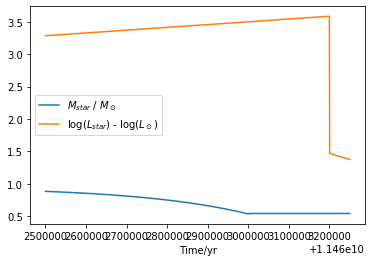

In [4]:
######################
# Get an array of masses and luminosities over the period of interest.
# This cell also plots those masses and luminosities.
######################

N_times = 1000
T0 = 1.14625e10
t_tot = 750000

ts = np.linspace(0, t_tot, N_times)
mtimes = masses(ts + T0)
lumins = lums_array(ts + T0)

plt.plot(ts + T0, mtimes)
plt.plot(ts + T0, lumins)
plt.legend([r"$M_{star}$ / $M_\odot$", r"log($L_{star}$) - log($L_\odot$)"])
plt.xlabel("Time/yr")
plt.show()

# Trojan analysis

Star initial mass: 0.8817936661802757 M_sol
Star initial age:  11462500000.0 yrs


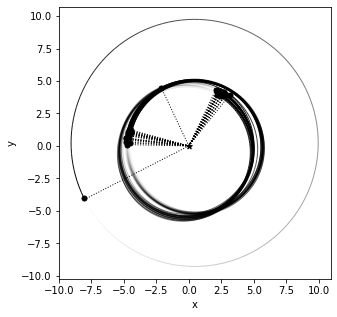

In [18]:
sim = rebound.Simulation()

M0 = mtimes[0]
print("Star initial mass:", M0, "M_sol")
print("Star initial age: ", T0, "yrs")

radeg = np.pi/180
Om_jup = 100.556*radeg
om_jup = 14.753*radeg

num_L4 = 20
num_L5 = 20
num_tr = num_L4 + num_L5

#############
# Add sun, trojans, Jupiter, and Saturn
#############

sim.add(m=M0,x=0, y=0, z=0, vx=0, vy=0, vz=0, hash='Sun')
add_L4(sim, num_L4)
add_L5(sim, num_L5)
sim.add(m=9.543e-4, a=5.2, e=.04839, inc=.022689, Omega=Om_jup, omega=om_jup, hash='jupiter')
sim.add(m=2.8575e-4, primary=sim.particles['Sun'], a=9.537, e=0.05415, inc=0.043284, Omega=1.9844, omega=1.61324, hash='Saturn')

#############
#set simulation parameters
#############

sim.dt = 0.5
sim.move_to_com()

ps = sim.particles
fig, ax = rebound.OrbitPlot(sim, periastron=True)

In [6]:
rad_ast = 10                                        # radius in km
troj_radii = np.full(num_tr, rad_ast/1.496e+8)      # gives each asteroid a radius in AU

mass_typic = 3*(4/3)*np.pi*(rad_ast*100000)**3      # gives typical mass @ this radius, w/ density = 3 g cm^-3
troj_masses = np.random.normal(mass_typic, .3*mass_typic, num_tr)        
                                                    # gives array of values around that mass
troj_masses /= 1.9891e33                            # divides each mass by M_sol to get masses in M_sol

print("Typical asteroid mass:", mass_typic, "g")
print("Average asteroid mass:", np.mean(troj_masses), "M_sol")

Typical asteroid mass: 1.2566370614359173e+19 g
Average asteroid mass: 5.476736042453135e-15 M_sol


In [7]:
Nout = 100000
times = np.linspace(0,t_tot,Nout)
mstar = np.zeros(Nout)

In [8]:
rebx = reboundx.Extras(sim)

starmass = reboundx.Interpolator(rebx, ts, mtimes, 'spline')

yrkv = rebx.create_force("yarkovsky")

yrkv.force_type = "vel"
yrkv.update_accelerations = yark
rebx.add_force(yrkv)

#gh = rebx.load_force("gravitational_harmonics")
#rebx.add_force(gh)

#mof = rebx.load_force("modify_orbits_forces")
#rebx.add_force(mof)

J2 = 14736e-6
J2prime = 0.045020
R_jup = 0.000477895

#ps['jupiter'].params["J2"] = J2prime
#ps['jupiter'].params["R_eq"] = R_jup

In [9]:
# initialize arrays for tracking progression of bodies over integration
mass = np.zeros(Nout)

x_sol = np.zeros(Nout); y_sol = np.zeros(Nout)
x_sol[0] = ps['Sun'].x
y_sol[0] = ps['Sun'].y

x_jup = np.zeros(Nout); y_jup = np.zeros(Nout)
x_jup[0] = ps['jupiter'].x
y_jup[0] = ps['jupiter'].y

a_jup = np.zeros(Nout)
e_jup = np.zeros(Nout) 
i_jup = np.zeros(Nout)
pmjup = np.zeros(Nout)
lmjup = np.zeros(Nout)

a_jup[0] = ps['jupiter'].a
e_jup[0] = ps['jupiter'].e
i_jup[0] = ps['jupiter'].inc
pmjup[0] = ps['jupiter'].pomega
lmjup[0] = ps['jupiter'].l

a_vals = np.zeros((num_tr, Nout))
e_vals = np.zeros((num_tr, Nout))
i_vals = np.zeros((num_tr, Nout))
pmvals = np.zeros((num_tr, Nout))
lmvals = np.zeros((num_tr, Nout))

x_vals = np.zeros((num_tr, Nout))
y_vals = np.zeros((num_tr, Nout))

for moon in range(num_L4):
    a_vals[moon,0] = ps['L4 {0}'.format(moon)].a
    e_vals[moon,0] = ps['L4 {0}'.format(moon)].e
    i_vals[moon,0] = ps['L4 {0}'.format(moon)].inc
    lmvals[moon,0] = ps['L4 {0}'.format(moon)].l
    pmvals[moon,0] = ps['L4 {0}'.format(moon)].pomega
    x_vals[moon,0] = ps['L4 {0}'.format(moon)].x
    y_vals[moon,0] = ps['L4 {0}'.format(moon)].y
    
for moon in range(num_L5):
    a_vals[moon + num_L4,0] = ps['L5 {0}'.format(moon)].a
    e_vals[moon + num_L4,0] = ps['L5 {0}'.format(moon)].e
    i_vals[moon + num_L4,0] = ps['L5 {0}'.format(moon)].inc
    lmvals[moon + num_L4,0] = ps['L5 {0}'.format(moon)].l
    pmvals[moon + num_L4,0] = ps['L5 {0}'.format(moon)].pomega
    x_vals[moon + num_L4,0] = ps['L5 {0}'.format(moon)].x
    y_vals[moon + num_L4,0] = ps['L5 {0}'.format(moon)].y

CPU times: user 6h 14min 14s, sys: 9.25 s, total: 6h 14min 23s
Wall time: 6h 15min 46s


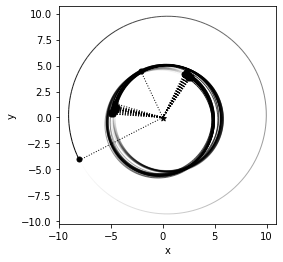

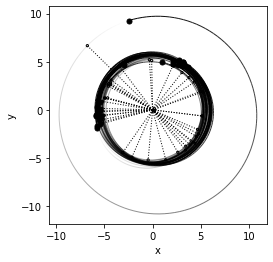

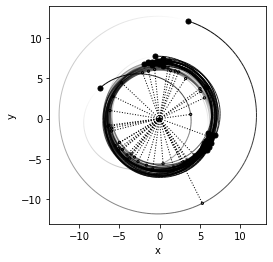

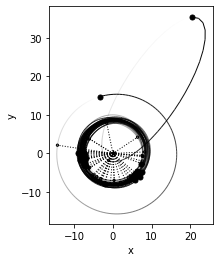

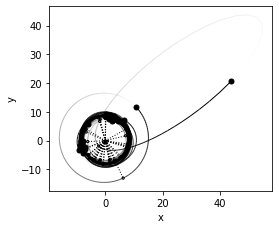

In [10]:
%%time

for i, time in enumerate(times):
    sim.integrate(time)
    
    ps[0].m = starmass.interpolate(rebx, t=sim.t)
    sim.move_to_com()
    
    mass[i] = ps['Sun'].m
    x_sol[i] = ps['Sun'].x
    y_sol[i] = ps['Sun'].y
    x_jup[i] = ps['jupiter'].x
    y_jup[i] = ps['jupiter'].y    
    a_jup[i] = ps['jupiter'].a
    e_jup[i] = ps['jupiter'].e
    i_jup[i] = ps['jupiter'].inc
    pmjup[i] = ps['jupiter'].pomega
    lmjup[i] = ps['jupiter'].l

    if i == 0:
        fig = rebound.OrbitPlot(sim, figsize=(4,4), periastron=True)
    if (i+1)%(Nout/4) == 0:
        fig = rebound.OrbitPlot(sim, figsize=(4,4), periastron=True)
    
    for moon in range(num_L4):
        a_vals[moon,i] = ps['L4 {0}'.format(moon)].a
        e_vals[moon,i] = ps['L4 {0}'.format(moon)].e
        i_vals[moon,i] = ps['L4 {0}'.format(moon)].inc
        lmvals[moon,i] = ps['L4 {0}'.format(moon)].l
        pmvals[moon,i] = ps['L4 {0}'.format(moon)].pomega
        x_vals[moon,i] = ps['L4 {0}'.format(moon)].x
        y_vals[moon,i] = ps['L4 {0}'.format(moon)].y

    for moon in range(num_L5):
        a_vals[moon + num_L4,i] = ps['L5 {0}'.format(moon)].a
        e_vals[moon + num_L4,i] = ps['L5 {0}'.format(moon)].e
        i_vals[moon + num_L4,i] = ps['L5 {0}'.format(moon)].inc
        lmvals[moon + num_L4,i] = ps['L5 {0}'.format(moon)].l
        pmvals[moon + num_L4,i] = ps['L5 {0}'.format(moon)].pomega
        x_vals[moon + num_L4,i] = ps['L5 {0}'.format(moon)].x
        y_vals[moon + num_L4,i] = ps['L5 {0}'.format(moon)].y

In [35]:
print(a_vals[11,:])

[ 5.23392575  5.23362728  5.2331063  ... 36.12891747 36.11144322
 36.10269035]


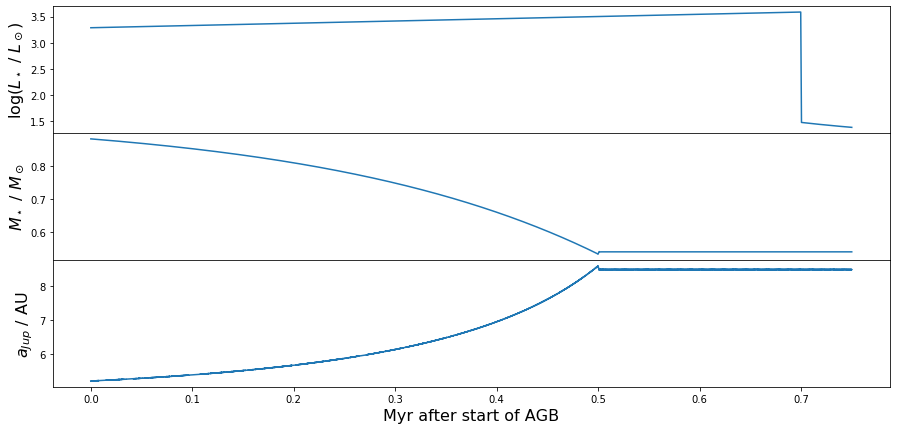

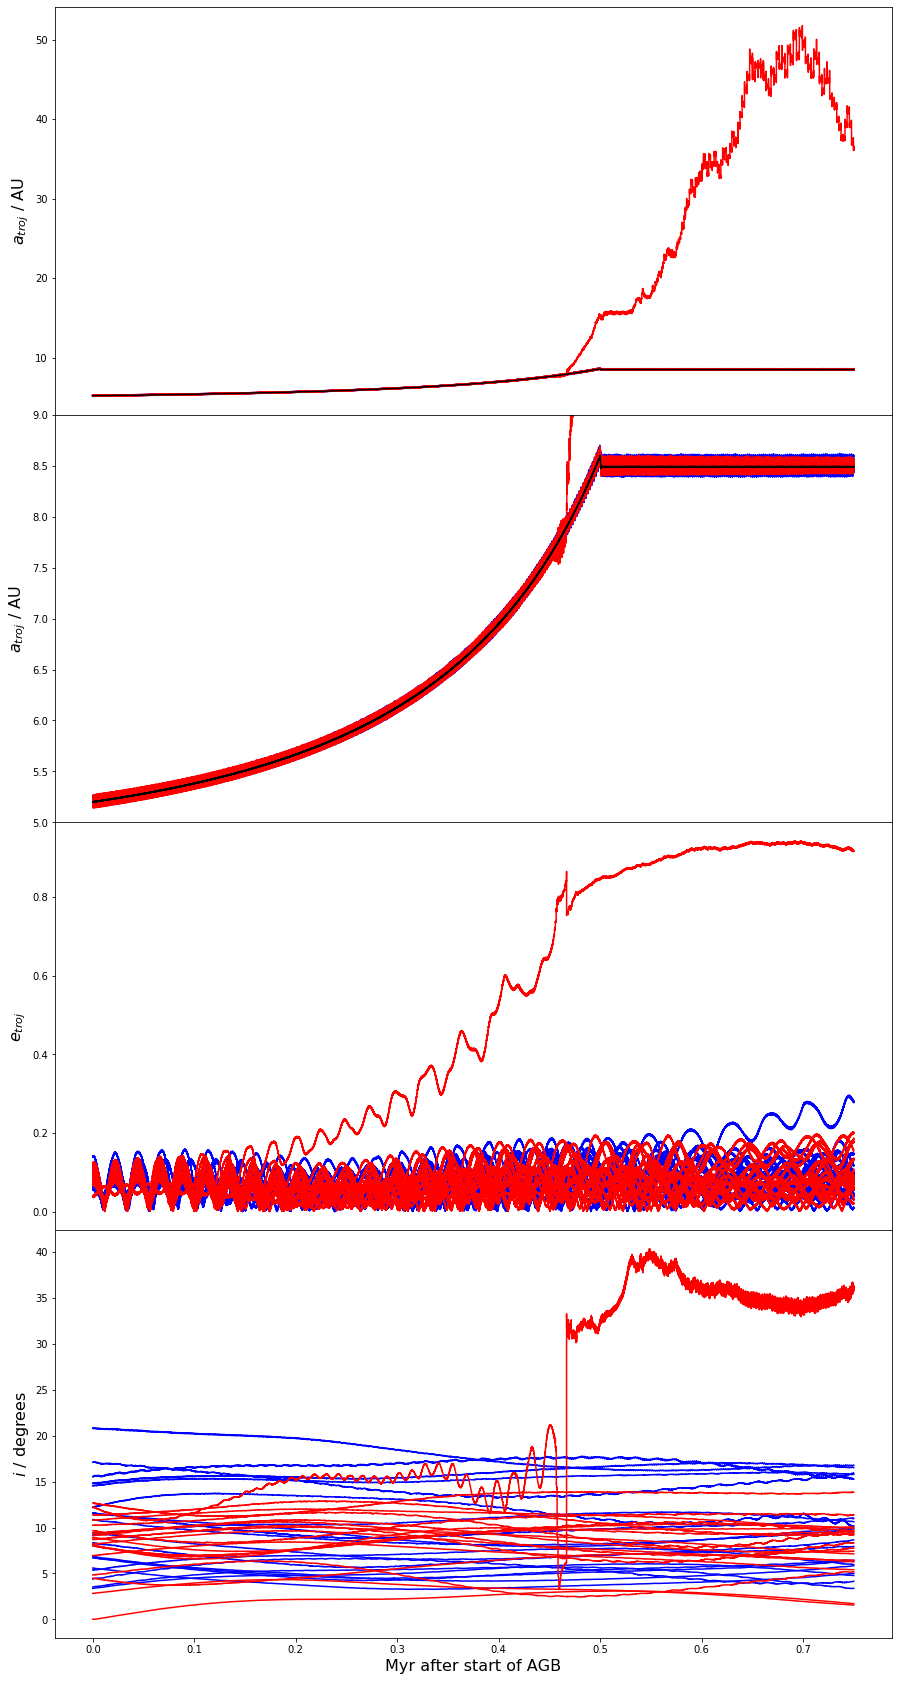

In [437]:
fig, ax = plt.subplots(3,1,figsize=(15,7), sharex=True)
plt.subplots_adjust(hspace=0)

end = 99999

ax[0].plot(ts/1e6,lumins)
ax[0].set_ylabel(r"log($L_\star$ / $L_\odot$)", fontsize=16)
ax[1].plot(times[:end]/1e6,mass[:end])
ax[1].set_ylabel(r"$M_\star$ / $M_\odot$", fontsize=16)
ax[2].plot(times[:end]/1e6,a_jup[:end])
ax[2].set_ylabel(r"$a_{Jup}$ / AU", fontsize=16)
ax[2].set_xlabel("Myr after start of AGB", fontsize=16)

fig.savefig("M-L-a-troj1.png")


trojs, axes = plt.subplots(4,1,figsize=(15,30), sharex=True)
plt.subplots_adjust(hspace=0)

axes[0].plot(times[:end]/1e6, a_vals.T[:end, num_L4:], 'b')
axes[0].plot(times[:end]/1e6, a_vals.T[:end, :num_L4], 'r')
axes[0].plot(times[:end]/1e6, a_jup[:end], "k")
axes[0].set_ylabel(r"$a_{troj}$ / AU", fontsize=16)
axes[1].plot(times[:end]/1e6, a_vals.T[:end, num_L4:], 'b')
axes[1].plot(times[:end]/1e6, a_vals.T[:end, :num_L4], 'r')
axes[1].plot(times[:end]/1e6, a_jup[:end], "k")
axes[1].set_ylim(5,9)
axes[1].set_ylabel(r"$a_{troj}$ / AU", fontsize=16)
axes[2].plot(times[:end]/1e6, e_vals.T[:end, num_L4:], 'b')
axes[2].plot(times[:end]/1e6, e_vals.T[:end, :num_L4], 'r')
axes[2].set_ylabel(r"$e_{troj}$", fontsize=16)
#axes[2].plot(times[:end], (lmvals.T[:end,20]), 'b')
#axes[2].plot(times[:end], (lmvals.T[:end,0]), 'r')
#axes[2].plot(times[:], signal.medfilt(Omvals.T[:, 0:5],[499,1]), 'r')
#axes[2].plot(times, change(Omvals.T)[:,1], 'k', a=3)
#axes[2].set_ylabel(r"$\lambda_{troj}$", fontsize=16)
axes[3].plot(times[:end]/1e6, i_vals.T[:end, num_L4:], 'b')
axes[3].plot(times[:end]/1e6, i_vals.T[:end, :num_L4], 'r')
axes[3].set_ylabel(r"$i$ / degrees", fontsize=16)
axes[3].set_xlabel("Myr after start of AGB", fontsize=16)
trojs.show()
trojs.savefig("ast-a-e-i-troj1.png")

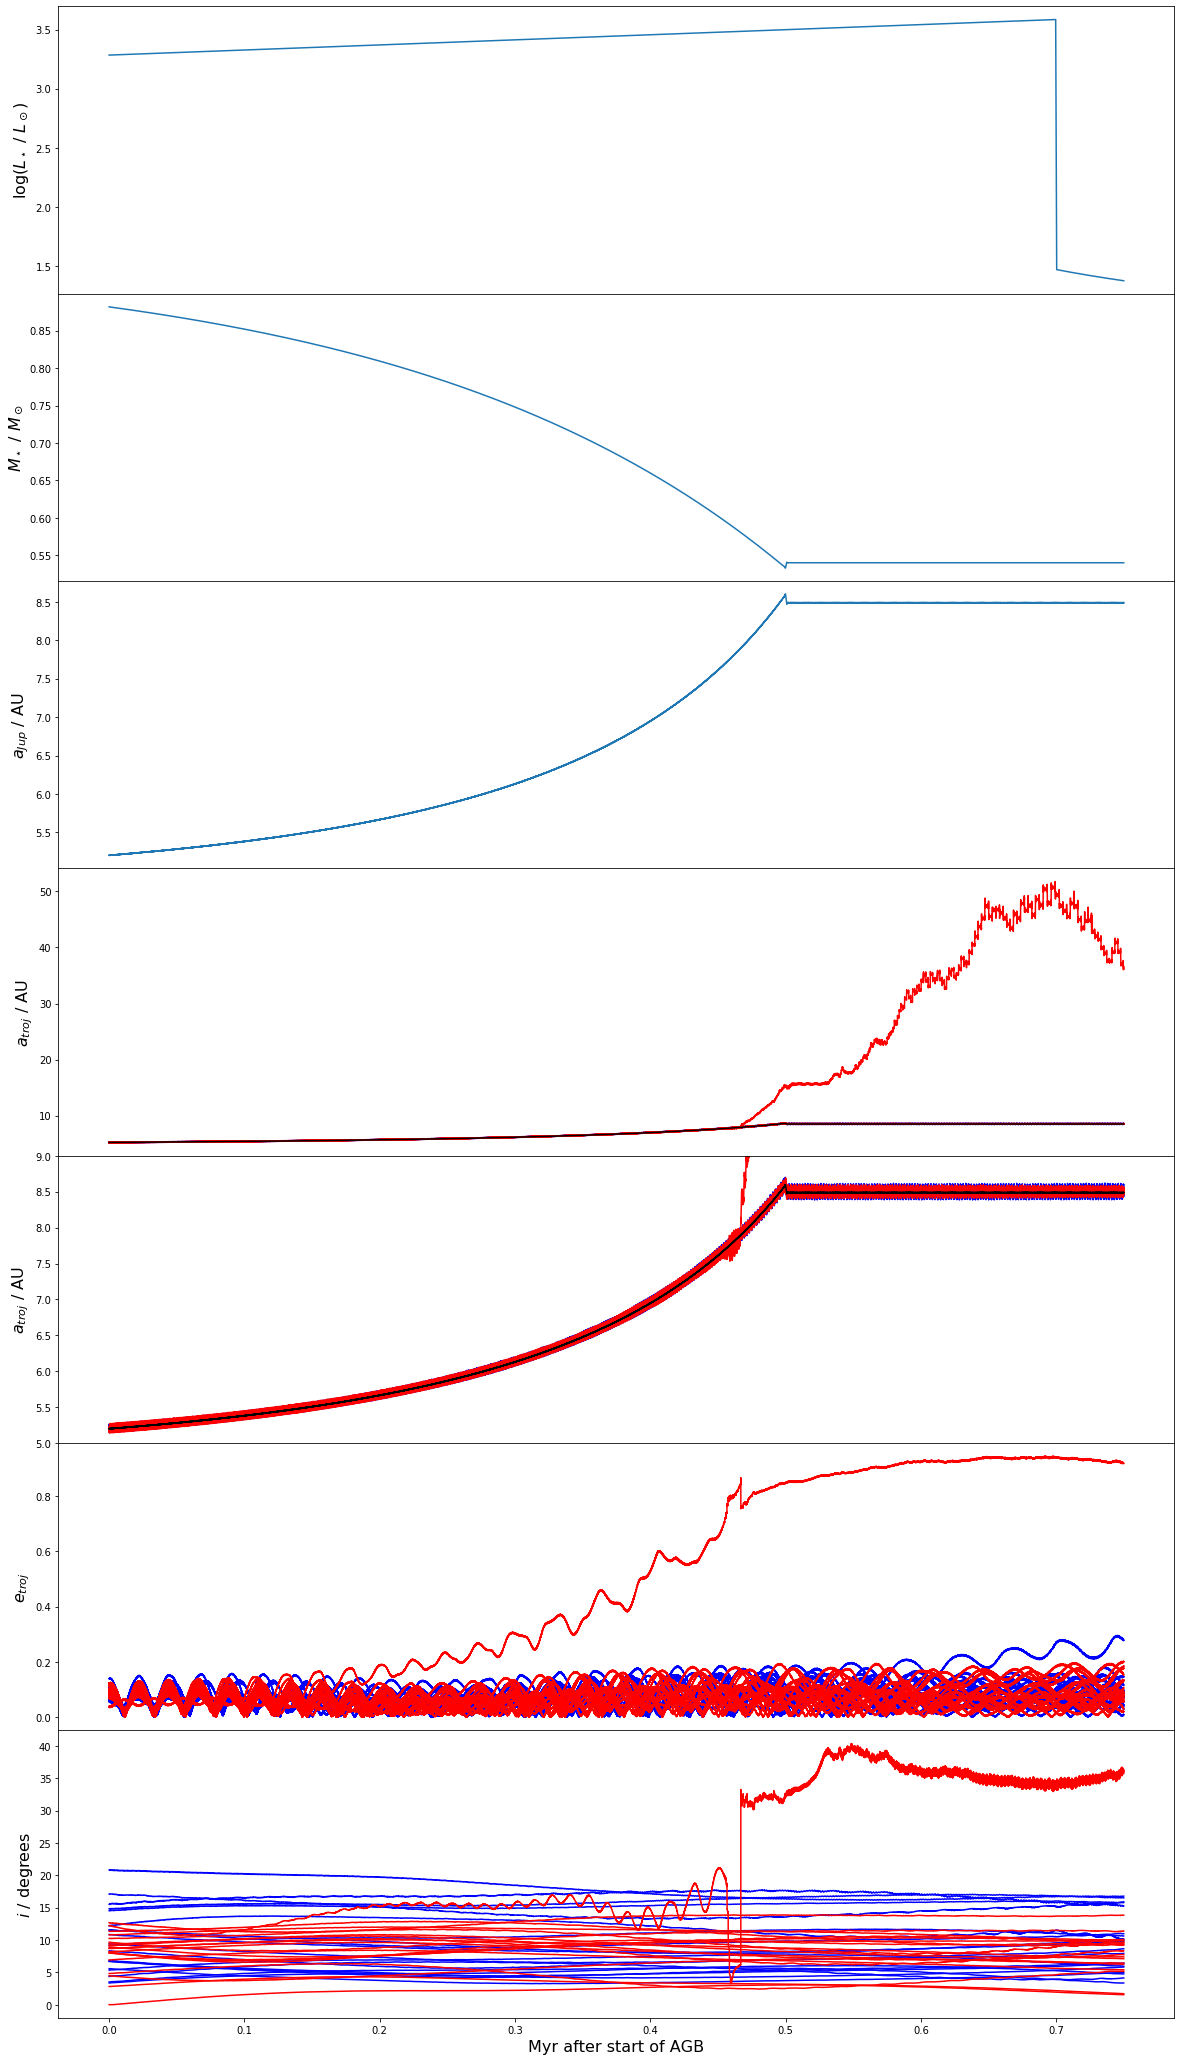

In [439]:
fig, ax = plt.subplots(7,1,figsize=(20,37), sharex=True)
plt.subplots_adjust(hspace=0)

end = 99999

ax[0].plot(ts/1e6,lumins)
ax[0].set_ylabel(r"log($L_\star$ / $L_\odot$)", fontsize=16)
ax[1].plot(times[:end]/1e6,mass[:end])
ax[1].set_ylabel(r"$M_\star$ / $M_\odot$", fontsize=16)
ax[2].plot(times[:end]/1e6,a_jup[:end])
ax[2].set_ylabel(r"$a_{Jup}$ / AU", fontsize=16)
ax[3].plot(times[:end]/1e6, a_vals.T[:end, num_L4:], 'b')
ax[3].plot(times[:end]/1e6, a_vals.T[:end, :num_L4], 'r')
ax[3].plot(times[:end]/1e6, a_jup[:end], "k")
ax[3].set_ylabel(r"$a_{troj}$ / AU", fontsize=16)
ax[4].plot(times[:end]/1e6, a_vals.T[:end, num_L4:], 'b')
ax[4].plot(times[:end]/1e6, a_vals.T[:end, :num_L4], 'r')
ax[4].plot(times[:end]/1e6, a_jup[:end], "k")
ax[4].set_ylim(5,9)
ax[4].set_ylabel(r"$a_{troj}$ / AU", fontsize=16)
ax[5].plot(times[:end]/1e6, e_vals.T[:end, num_L4:], 'b')
ax[5].plot(times[:end]/1e6, e_vals.T[:end, :num_L4], 'r')
ax[5].set_ylabel(r"$e_{troj}$", fontsize=16)
ax[6].plot(times[:end]/1e6, i_vals.T[:end, num_L4:], 'b')
ax[6].plot(times[:end]/1e6, i_vals.T[:end, :num_L4], 'r')
ax[6].set_ylabel(r"$i$ / degrees", fontsize=16)
ax[6].set_xlabel("Myr after start of AGB", fontsize=16)

fig.show()
fig.savefig("troj1-all-elements.png", dpi=300)

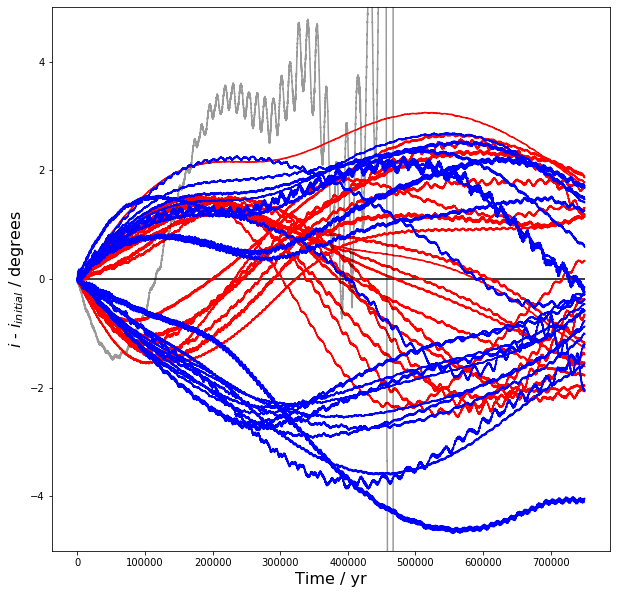

In [440]:
i_inits = i_vals[:,0]
i_diffs = np.zeros_like(i_vals)
for time in range(end):
    i_diffs[:,time] = i_vals[:,time] - i_inits

fig,ax = plt.subplots(figsize=(10,10))
ax.plot(times[:end],i_diffs.T[:end,0:11],'r')
ax.plot(times[:end],i_diffs.T[:end,11],'k', alpha=.4)
ax.plot(times[:end],i_diffs.T[:end,12:num_L4],'r')
ax.plot(times[:end],i_diffs.T[:end,num_L4:],'b')
ax.set_ylim(-5,5)
ax.set_ylabel(r"$i$ - $i_{initial}$ / degrees", fontsize=16)
ax.set_xlabel("Time / yr", fontsize=16)
ax.hlines(0,xmin=0,xmax=750000)
fig.show()
fig.savefig("i_changes_troj1.png", dpi=300)

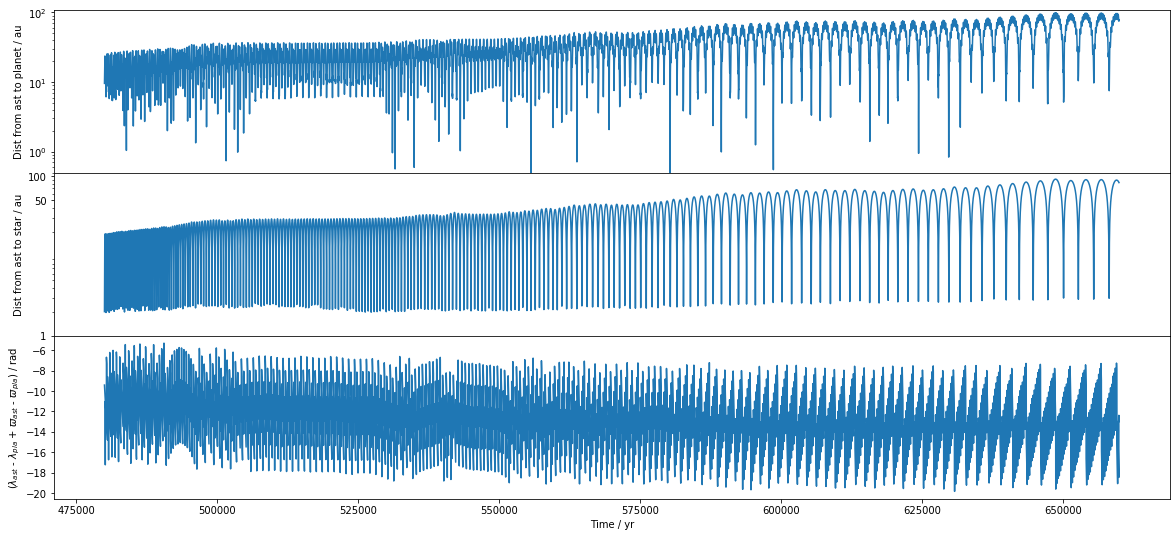

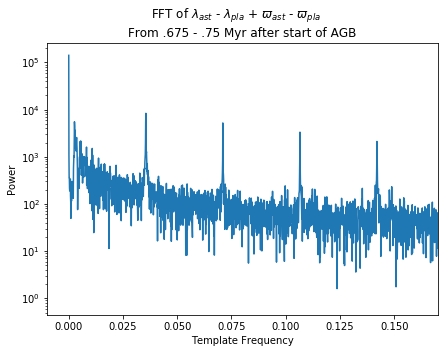

In [454]:
fig6_vals = lmvals[11,:] - lmjup[:] + pmvals[11,:] - pmjup[:]
jup_dists = np.sqrt((x_vals[11,:] - x_jup[:])**2 + (y_vals[11,:] - y_jup[:])**2)
sol_dists = np.sqrt((x_vals[11,:] - x_sol[:])**2 + (y_vals[11,:] - y_sol[:])**2)

fig, ax = plt.subplots(3, figsize=(20,9))
plt.subplots_adjust(hspace=0)

ax[0].plot(times[-36000:-12000],jup_dists.T[-36000:-12000])
ax[0].set_ylabel(r"Dist from ast to planet / au")
ax[0].set_ylim(0.5,110)
ax[0].set_yticks([1,50,100])
ax[0].set_yticklabels([1,50,100])
ax[0].set_yscale("log")

ax[1].plot(times[-36000:-12000],sol_dists.T[-36000:-12000])
ax[1].set_ylabel(r"Dist from ast to star / au")
ax[1].set_ylim(1,110)
ax[1].set_yscale("log")
ax[1].set_yticks([1,50,100])
ax[1].set_yticklabels([1,50,100])

ax[2].plot(times[-36000:-12000],(fig6_vals[-36000:-12000]))
ax[2].set_ylabel(r"($\lambda_{ast}$ - $\lambda_{pla}$ + $\varpi_{ast}$ - $\varpi_{pla}$) / rad")
ax[2].set_xlabel("Time / yr")
fig.show()
fig.savefig("weird-asteroid-stuff-troj1.png", dpi=300)

fft_lambda = scipy.fft.rfft(fig6_vals[-11000:end])
freq = scipy.fft.rfftfreq(times[-11000:end].shape[-1])

fig3, ax3 = plt.subplots(1, figsize=(7,5))
ax3.plot(freq,np.abs(fft_lambda))
ax3.set_xlabel("Template Frequency")
ax3.set_ylabel("Power")
ax3.set_title("From .675 - .75 Myr after start of AGB")
fig3.suptitle(r"FFT of $\lambda_{ast}$ - $\lambda_{pla}$ + $\varpi_{ast}$ - $\varpi_{pla}$")
ax3.set_xlim(-0.01,0.17)
ax3.set_yscale("log")
fig3.show()
fig3.savefig("weird-asteroid-FFT-troj1.png", dpi=300)

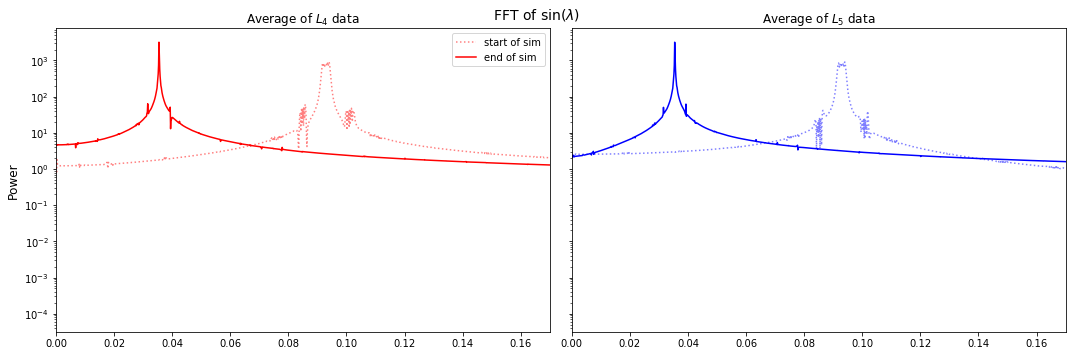

In [153]:
fft_4lambda1 = scipy.fft.rfft(np.sin(lmvals.T[end-7500:end,:10]), axis=0)
fft_4lambda2 = scipy.fft.rfft(np.sin(lmvals.T[0:7500,:10]), axis=0)
fft_5lambda1 = scipy.fft.rfft(np.sin(lmvals.T[end-7500:end,num_L4:]), axis=0)
fft_5lambda2 = scipy.fft.rfft(np.sin(lmvals.T[0:7500,num_L4:]), axis=0)
freq = scipy.fft.rfftfreq(times[0:7500].shape[-1])

fig, ax = plt.subplots(1,2, figsize=(15,5), sharey=True)
ax[0].plot(freq,np.abs(np.mean(fft_4lambda2, axis=1)), c="r", ls=":", alpha=.5)
ax[0].plot(freq,np.abs(np.mean(fft_4lambda1, axis=1)), c="r")
ax[1].plot(freq,np.abs(np.mean(fft_5lambda2, axis=1)), c="b", ls=":", alpha=.5)
ax[1].plot(freq,np.abs(np.mean(fft_5lambda1, axis=1)), c="b")
for i in range(2):
    ax[i].set_yscale("log")
    ax[i].set_xlim(0,0.17)
fig.suptitle(r"FFT of sin($\lambda$)", fontsize=14)
ax[0].legend(["start of sim", "end of sim"])
ax[0].set_title(r"Average of $L_4$ data")
ax[1].set_title(r"Average of $L_5$ data")
ax[0].set_ylabel("Power", fontsize=12)
fig.tight_layout()
fig.show()

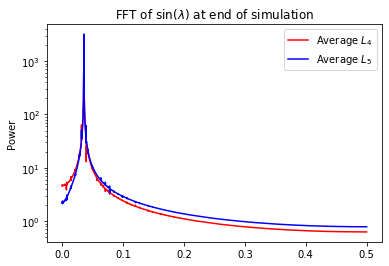

In [154]:
plt.plot(freq,np.abs(np.mean(fft_4lambda1, axis=1)), "r")
plt.plot(freq,np.abs(np.mean(fft_5lambda1, axis=1)), "b")
plt.yscale("log")
plt.ylabel("Power")
plt.legend([r"Average $L_4$",r"Average $L_5$"])
plt.title(r"FFT of sin($\lambda$) at end of simulation")
plt.show()

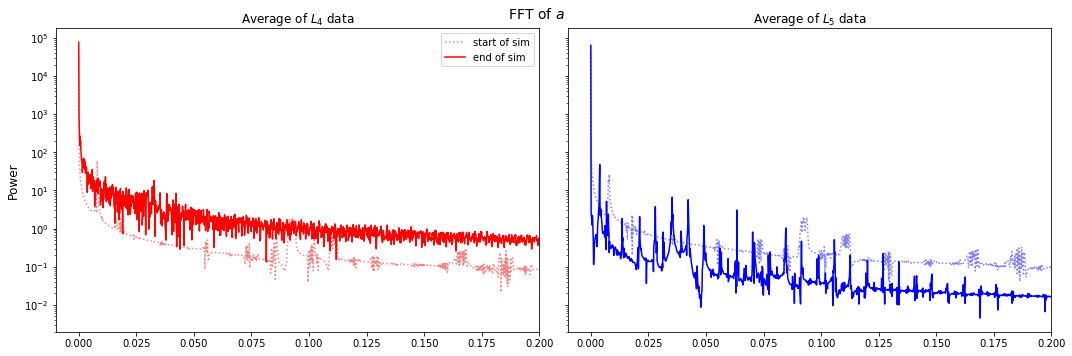

In [22]:
fft_4lambda1 = scipy.fft.rfft(a_vals.T[end-7500:end,:num_L4], axis=0)
fft_4lambda2 = scipy.fft.rfft(a_vals.T[0:7500,:num_L4], axis=0)
fft_5lambda1 = scipy.fft.rfft(a_vals.T[end-7500:end,num_L4:], axis=0)
fft_5lambda2 = scipy.fft.rfft(a_vals.T[0:7500,num_L4:], axis=0)
freq = scipy.fft.rfftfreq(times[0:7500].shape[-1])

fig, ax = plt.subplots(1,2, figsize=(15,5), sharey=True)
ax[0].plot(freq,np.abs(np.mean(fft_4lambda2, axis=1)), c="r", ls=":", alpha=.5)
ax[0].plot(freq,np.abs(np.mean(fft_4lambda1, axis=1)), c="r")
ax[1].plot(freq,np.abs(np.mean(fft_5lambda2, axis=1)), c="b", ls=":", alpha=.5)
ax[1].plot(freq,np.abs(np.mean(fft_5lambda1, axis=1)), c="b")
for i in range(2):
    ax[i].set_yscale("log")
    ax[i].set_xlim(-0.01,0.2)
fig.suptitle(r"FFT of $a$", fontsize=14)
ax[0].legend(["start of sim", "end of sim"])
ax[0].set_title(r"Average of $L_4$ data")
ax[1].set_title(r"Average of $L_5$ data")
ax[0].set_ylabel("Power", fontsize=12)
fig.tight_layout()
fig.show()

In [382]:
def roch2(x,y,M1,M2,a):
    q = M2/M1
    x /= a
    y /= a
    s1 = np.sqrt(x**2 + y**2)
    s2 = np.sqrt((x-1)**2 + y**2)
    
    term1 = 2/(s1*(1+q))
    term2 = 2*q/(s2*(1+q))
    term3 = (x - q/(1+q))**2
    term4 = y**2
    return term1 + term2 + term3 + term4

def cart_to_pol(x,y):
    r = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y,x)
    return r, phi

def pol_to_cart(r,phi):
    x = r*np.cos(phi)
    y = r*np.sin(phi)
    return x, y

def L45(xjup,yjup,xsun,ysun):
    phi_jup = np.arctan2(yjup,xjup)
    
    phi_L4 = phi_jup + np.pi/3
    phi_L5 = phi_jup - np.pi/3
    
    xsep = (xsun - xjup)
    ysep = (ysun - yjup)
    
    r_jupsol = np.sqrt(xsep**2 + ysep**2)
    
    x_L4 = r_jupsol*np.cos(phi_L4)
    x_L5 = r_jupsol*np.cos(phi_L5)
    y_L4 = r_jupsol*np.sin(phi_L4)
    y_L5 = r_jupsol*np.sin(phi_L5)
    
    return np.array([x_L4,x_L5]), np.array([y_L4,y_L5])

G = 4*np.pi**2

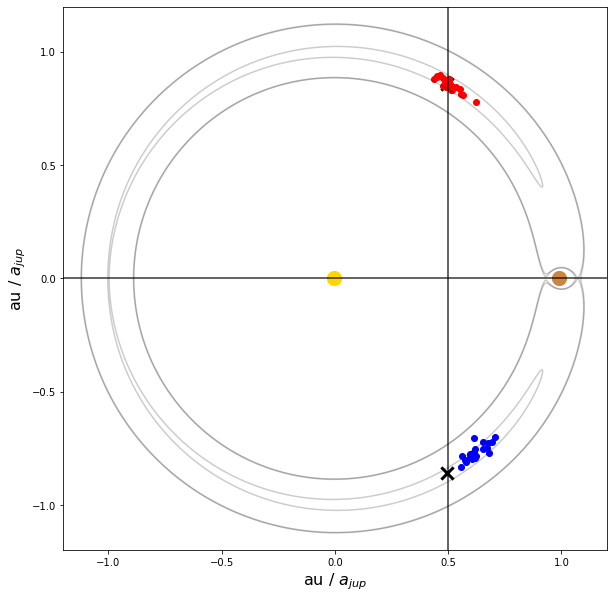

In [441]:
end = 3

delta = 0.01
x1 = np.arange(-7, 7, delta)
y1 = np.arange(-7, 7, delta)
X1, Y1 = np.meshgrid(x1, y1)

a_fin = a_jup[end]+0.1

Z1 = roch2(X1,Y1,mass[end],9.543e-4,a_fin)

jup_x = x_jup[end]/a_fin; jup_y = y_jup[end]/a_fin
sol_x = x_sol[end]/a_fin; sol_y = y_sol[end]/a_fin

ast_x = x_vals.T[end,:]/a_fin; ast_y = y_vals.T[end,:]/a_fin

L45_x, L45_y = L45(jup_x,jup_y,sol_x,sol_y)

ast_r, ast_phi = cart_to_pol(ast_x,ast_y)
sol_r, sol_phi = cart_to_pol(sol_x,sol_y)
jup_r, jup_phi = cart_to_pol(jup_x,jup_y)
L45_r, L45_phi = cart_to_pol(L45_x,L45_y)

ast_phi -= jup_phi
sol_phi -= jup_phi
L45_phi -= jup_phi
jup_phi -= jup_phi

ast_x, ast_y = pol_to_cart(ast_r,ast_phi)
sol_x, sol_y = pol_to_cart(sol_r,sol_phi)
jup_x, jup_y = pol_to_cart(jup_r,jup_phi)
L45_x, L45_y = pol_to_cart(L45_r,L45_phi)

fig, ax = plt.subplots(figsize=(10,10))

lines1 = np.array([3.00111,3.0406,3.0418])

ax.contour(X1,Y1,Z1,lines1, colors='k', alpha=.2)
ax.scatter(L45_x,L45_y, c='k', lw=3,s=150, marker="x")
ax.scatter(ast_x[:num_L4],ast_y[:num_L4],c="r")
ax.scatter(ast_x[num_L4:],ast_y[num_L4:],c="b")
ax.scatter(sol_x,sol_y, c="gold",s=200)
ax.scatter(jup_x,jup_y, c="peru",s=200)

ax.axhline(0, c='k', alpha=.8)
ax.axvline(.5, c='k', alpha=.8)
ax.set_aspect("equal")
ax.set_ylim(-1.2,1.2)
ax.set_xlim(-1.2,1.2)
ax.set_xlabel(r"au / $a_{jup}$", fontsize=16)
ax.set_ylabel(r"au / $a_{jup}$", fontsize=16)
fig.show()
fig.savefig("troj-1-ast-on-separatrix-start.png", dpi=300)

end = 99999

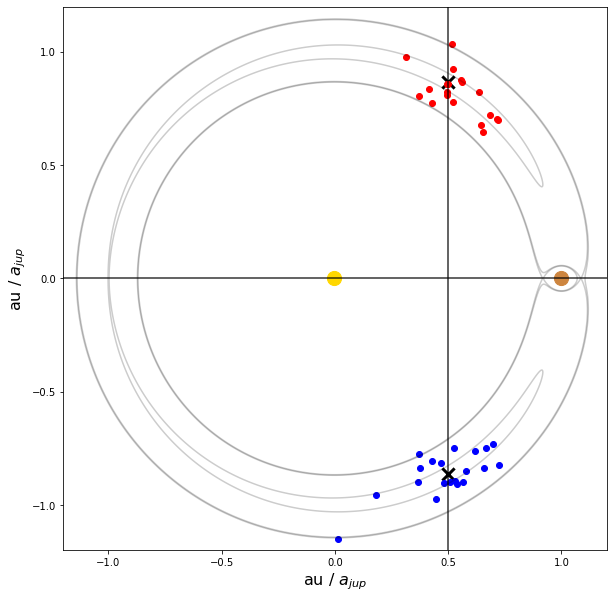

In [442]:
delta = 0.01
x1 = np.arange(-11, 11, delta)
y1 = np.arange(-11, 11, delta)
X1, Y1 = np.meshgrid(x1, y1)

Z1 = roch2(X1,Y1,mass[end],9.543e-4, a_jup[end])

lines1 = np.array([3.00178,3.055,3.0574])
u1, u2, u3 = lines1

a_fin = a_jup[end]

jup_x = x_jup[end]/a_fin; jup_y = y_jup[end]/a_fin
sol_x = x_sol[end]/a_fin; sol_y = y_sol[end]/a_fin

ast_x = x_vals.T[end,:]/a_fin; ast_y = y_vals.T[end,:]/a_fin

L45_x, L45_y = L45(jup_x,jup_y,sol_x,sol_y)

ast_r, ast_phi = cart_to_pol(ast_x,ast_y)
sol_r, sol_phi = cart_to_pol(sol_x,sol_y)
jup_r, jup_phi = cart_to_pol(jup_x,jup_y)
L45_r, L45_phi = cart_to_pol(L45_x,L45_y)

ast_phi -= jup_phi
sol_phi -= jup_phi
L45_phi -= jup_phi
jup_phi -= jup_phi

ast_x, ast_y = pol_to_cart(ast_r,ast_phi)
sol_x, sol_y = pol_to_cart(sol_r,sol_phi)
jup_x, jup_y = pol_to_cart(jup_r,jup_phi)
L45_x, L45_y = pol_to_cart(L45_r,L45_phi)

fig, ax = plt.subplots(figsize=(10,10))

ax.contour(X1,Y1,Z1,lines1, colors='k', alpha=.2)
ax.scatter(L45_x,L45_y, c='k', lw=3,s=150, marker="x")
ax.scatter(ast_x[:num_L4],ast_y[:num_L4],c="r")
ax.scatter(ast_x[num_L4:],ast_y[num_L4:],c="b")
ax.scatter(sol_x,sol_y, c="gold",s=200)
ax.scatter(jup_x,jup_y, c="peru",s=200)

ax.axhline(0, c='k', alpha=.8)
ax.axvline(.5, c='k', alpha=.8)
ax.set_aspect("equal")
ax.set_ylim(-1.2,1.2)
ax.set_xlim(-1.2,1.2)
ax.set_xlabel(r"au / $a_{jup}$", fontsize=16)
ax.set_ylabel(r"au / $a_{jup}$", fontsize=16)
fig.show()
fig.savefig("troj1-ast-on-separatrix.png", dpi=300)

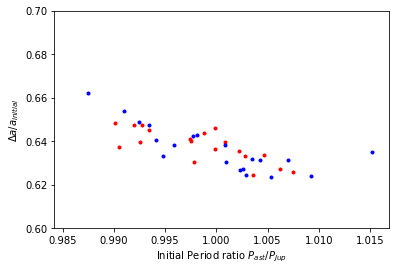

In [386]:
a_inits_L4 = a_vals.T[0,:num_L4]    ; a_inits_L5 = a_vals.T[0,num_L4:]
a_final_L4 = a_vals.T[Nout-1,:num_L4] ; a_final_L5 = a_vals.T[Nout-1,num_L4:]

plt.scatter(np.power(a_inits_L4,1.5)/a_jup[0]**1.5, (np.fabs(a_final_L4-a_inits_L4)+1.0e-16)/a_inits_L4,marker=".",s=36,c="r")
plt.scatter(np.power(a_inits_L5,1.5)/a_jup[0]**1.5, (np.fabs(a_final_L5-a_inits_L5)+1.0e-16)/a_inits_L5,marker=".",s=36,c="b")
plt.xlabel(r"Initial Period ratio $P_{ast}/P_{Jup}$")
plt.ylabel(r"$\Delta a/a_{initial}$")
plt.ylim(0.6,.7)
plt.yscale("linear")
plt.show()

Idea for this plot came from https://rebound.readthedocs.io/en/latest/ipython/Testparticles.html -- doesn't look quite as cool as the one there, perhaps I need more particles

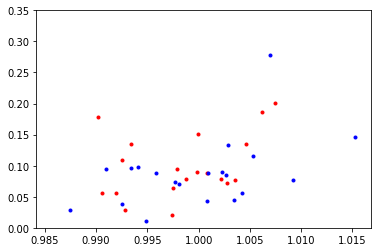

In [299]:
e_final_L4 = e_vals.T[end,:num_L4]
e_final_L5 = e_vals.T[end,num_L5:]

plt.scatter(np.power(a_inits_L4,1.5)/a_jup[0]**1.5, (e_final_L4)+1.0e-16,marker=".",s=36,c="r")
plt.scatter(np.power(a_inits_L5,1.5)/a_jup[0]**1.5, (e_final_L5)+1.0e-16,marker=".",s=36,c="b")
plt.yscale("linear")
plt.ylim(0,.35)
plt.show()

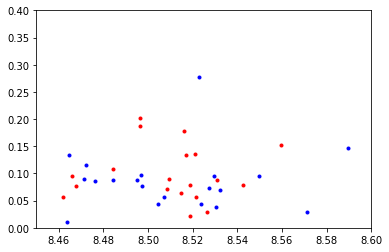

In [300]:
plt.scatter(a_final_L4,e_final_L4,marker=".",s=36,c='r')
plt.scatter(a_final_L5,e_final_L5,marker=".",s=36,c='b')
plt.xlim(8.45,8.6)
plt.ylim(0,0.4)
plt.show()

In [455]:
def xy_to_L45(astx,asty,L4x,L4y,L5x,L5y):
    print(L4x.shape)
    print(astx.shape)
    print(L4x)
    print(astx)

    xdiff4 = astx - L4x; ydiff4 = asty - L4y
    xdiff5 = astx - L5x; ydiff5 = asty - L5y
    
    dist4 = np.sqrt(xdiff4**2 + ydiff4**2)
    print(dist4)
    dist5 = np.sqrt(xdiff5**2 + ydiff5**2)

    return signal.medfilt(dist4,499), signal.medfilt(dist5,499)

In [456]:
L45_x, L45_y = L45(x_jup,y_jup,x_sol,y_sol)

In [ ]:
d4, d5 = xy_to_L45(x_vals[:5,:],y_vals[:5,:],L45_x,L45_y)
print(d4)

In [ ]:
plt.plot(times[:end],d4)
plt.show()

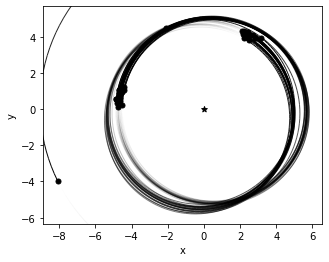

In [453]:
fig, axmain = rebound.OrbitPlot(sim)
fig.savefig("troj1-wideview-orbs.png", dpi=300)
fig.show()